# Tuto 007 : Super-Elements and 3D blade study

In this tutorial, the concept of super-elements is introduced using Craig-Bampton method onto a simple Euler beam model. In a second part, an analysis of a 3D model of a bladed disk sector is made using the provided super-elements and reduction methods are used in order to see the impact of those onto the computation time.

1. Concept of super-elements : 
    - build a beam elementary matrices using Euler beam theory
    - conduct the modal analysis of the beam 
    - Realise a forced reponse analysis
    - compute the static modes
    - generate the CB super-element and check convergence of the reduced model
    - make the forced response analysis using the super-element
2. 3D model of a bladed disk sector : 
    - build input dictionary for pyHarm
    - compute the forced response analysis using different reduction methods


## 0. Imports and helper functions

This section is composed of basic imports and helper function that will be used in the tutorial. 

In [1]:
print("Kernel has started if displayed")

Kernel has started if displayed


In [2]:
## This block makes the mandatory imports and configure matplotlib for figures
## Some help function is also defined here (get_frf)
import sys
PATH_TO_PYHARM = False
PATH_TO_PYHARM = "../"
if PATH_TO_PYHARM !=False : 
    sys.path.append(PATH_TO_PYHARM)
# ------------------ IMPORTS ------------------ #
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyHarm
import pandas as pd 

# ------------------ MATPLOTLIB DEFAULT STYLE ------------------ #
plt.style.use('default')
FONT_BASE = 18
width_fig = 8
ratio_fig = (width_fig,1/(16/10.)*width_fig)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
plt.rc('xtick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_BASE)    # legend fontsize
plt.rc('axes', labelsize=FONT_BASE)
plt.rc('axes', titlesize=FONT_BASE+5) # fontsize of the title

BASE_CMAP_NAME = "RdYlGn_r"
BASE_CMAP = cm.get_cmap(BASE_CMAP_NAME, 2)


style_plots_ref = {"frf_lin":{"linestyle":"dashed","color":np.zeros(3,),\
                          "label":"Linear solution","linewidth":3},\
                   "frf_lin_slide":{"linestyle":"dashed","color":BASE_CMAP(0),\
                          "label":"Linear solution sliding","linewidth":3},\
                   "frf_lin_stuck":{"linestyle":"dashed","color":BASE_CMAP(1),\
                          "label":"Linear solution stuck","linewidth":3},\
                   "frf_fric":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":None},\
                  }
SAVE = False

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100. 
import matplotlib.animation
%matplotlib inline

# ------------------ helper functions ------------------ #
def get_frf(M:pyHarm.Maestro,sub="beam",node=0,direction=0,deriv:int=0) :
    if M.system.adim : 
        lc, wc = M.system.lc, M.system.wc
    else :
        lc, wc = 1., 1. 
    index_kept = M.getIndex(sub,node,direction)
    SA = [sol for sol in M.nls["FRF"].SolList if sol.flag_accepted]
    om = np.array([sol.x[-1] * wc for sol in SA])
    nabla = M.system.LE[0].nabla 
    D = M.system.LE[0].D 
    nablo = np.linalg.matrix_power(nabla,deriv)
    amp = np.array([np.linalg.norm(sol.x[-1]**(deriv)*nablo@( M.system.get_full_disp(sol.x)[index_kept] * lc )) for k,sol in enumerate(SA)])
    return om, amp 


def prep_fig(fp):
    fig,ax = plt.subplots(figsize=ratio_fig)
    ax.set_xticks(fp)
    ax.set_xticklabels([f"{f:.2e}" for f in fp])
    ax.grid()
    ax.set_yscale("log")
    return fig,ax

## 1. Beam model and generation of Craig-Bampton super-element 

The following block consists in giving the basic parameters of the beam studied in the tutorial.
The elementary matrices are provided and correspond to Euler Bernoulli beam theory for a full circular section beam.

In [3]:
# --------------------- SOME PARAMETERS --------------------- #


## ------ FEM properties ------ ##
length_beam = 1 # original value = 1
number_elements = 50 # original value = 20
number_nodes = number_elements + 1 # NOT A PARAMETER 
length_element = length_beam / number_elements # NOT A PARAMETER 


## ------ Material & section properties ------ ##
### -- Material -- ###
rho = 7800 # original value = 7800
E = 210e9 # original value = 210e9

### -- Circular beam properties -- ###
radius = 1e-2 # original value = 1e-2
A = np.pi * radius**2 # NOT A PARAMETER 
I = np.pi * radius**4 / 16. # NOT A PARAMETER 

## ------ Elementary matrices for Euler Bernoulli beam ------ ##

### -- Upper triangle matrices -- ###
# with flexural dofs (transverse displacement + rotation) -> [y, theta]
Me_trisup = rho*A*length_element / 420. * np.array([
    [156, 22*length_element, 54, -13*length_element],
    [0, 4*length_element**2, 13*length_element, -3*length_element**2],
    [0, 0, 156, -22*length_element],
    [0, 0, 0, 4*length_element**2],
])
Ke_trisup = E*I/length_element**3 * np.array([
    [ 12, 6*length_element, -12, 6*length_element],
    [ 0, 4*length_element**2, -6*length_element, 2*length_element**2],
    [ 0, 0, 12, -6*length_element],
    [ 0, 0, 0, 4*length_element**2],
])

### -- Full matrices from the triangle -- ###
Me = Me_trisup + Me_trisup.T - np.diag(np.diag(Me_trisup))
Ke = Ke_trisup + Ke_trisup.T - np.diag(np.diag(Ke_trisup))




## 1.1 Build connector that adds elementary matrix

In the next block, a general connector is built such that it adds an elementary matrix contribution to the residual equations. The `ElementaryMatrix` class is provided and commented, the purpose is to complete the residual and jacobian functions.

Given an elementary matrix $A_{e}$ and knowing the order of time derivative `dto`, the residual contribution is given by : 

$$ R = \omega^{dto} \cdot (\nabla^{dto} \otimes A_{e}) \cdot \tilde{x}$$

- Complete `ElementaryMatrixResidual` function that returns the residual contribution of the provided elementary matrix
- Complete `ElementaryMatrixJacobian` function that returns the jacobians of the provided elementary matrix


In [4]:
# ------------------ Create Custom connector that would add the full damping matrix ------------------ #
from pyHarm.Elements.NodeToNodeElements.NodeToNodeElement import NodeToNodeElement
from Tuto_007_SuperElements_3D_Blade_correctionfunctions import ElementaryMatrixResidual_corr, ElementaryMatrixJacobian_corr

## ------ FUNCTIONS TO COMPLETE ------ ##
def ElementaryMatrixResidual(x:np.ndarray,om:float,kronAe:np.ndarray,dto:int) -> np.ndarray:
    R = np.zeros(x.shape)
    # complete the function in order to return the right residual
    return R

def ElementaryMatrixJacobian(x:np.ndarray,om:float,kronAe:np.ndarray,dto:int) -> tuple[np.ndarray,np.ndarray]:
    dJdx = np.zeros((x.shape[0],x.shape[0]))
    dJdom = np.zeros(x.shape)
    # complete the function in order to return the right jacobians
    return dJdx,dJdom

## ------ ELEMENT CLASS ------ ##
class ElementaryMatrix(NodeToNodeElement) : 
    factory_keyword = "ElementaryMatrix" # name to call the class in pyHarm once added to factory
    
    def __post_init__(self):
        self.dto = self.data["dto"] # order of the derivative 
        ### the kronecker product is made in the initialisation at it never changes !
        self.kronAe = np.kron(np.linalg.matrix_power(self.nabla,self.dto),self.data["A"])
        
    def adim(self, lc:float, wc:float) -> None:
        self.kronAe = self.kronAe * lc * (wc**self.dto)
        
    def evalResidual(self,xg,om):
        x = xg[self.indices] # get the indices of the element
        # compute residual
        self.R = ElementaryMatrixResidual_corr(x,om,self.kronAe,self.dto) # change with your function
        return self.R
    
    def evalJacobian(self,xg,om):
        x = xg[self.indices] # get the indices of the element
        # compute jacobians
        self.J, self.dJdom = ElementaryMatrixJacobian_corr(x,om,self.kronAe,self.dto) # change with your function
        return self.J, self.dJdom
        

## 1.2 Build a system in pyHarm that represents the beam.

### 1.2.1 Complete the input dictionary
In the next blocks, an input dictionary is built in order to be able to construct the beam system.
The first step is to create an empty substructure with the right number of total dofs and nodes. Each node is then connected using the previously created connector.

- Complete `add_EM_connectors` function that adds an `ElementaryMatrix` connector for each element of the discretised beam.

In [5]:
# ------------------ Input dictionary construction  ------------------ #
## ------ GIVEN DATA ------ ##
# The substructure of the beam is going to be represented by using only null matrices here
beam_null_mat = {
    "M": np.zeros((2*number_nodes, 2*number_nodes)), # 2 dofs per node
    "C": np.zeros((2*number_nodes, 2*number_nodes)),
    "G": np.zeros((2*number_nodes, 2*number_nodes)),
    "K": np.zeros((2*number_nodes, 2*number_nodes)),
}

INP = {
    "system":{
        "type":"Base",
        "nh":1,
        "nti":128
    },
    "substructures":{
        "beam":{
            "matrix":beam_null_mat,
            "ndofs":2 # 2 dofs per node
        }
    },
    "connectors":{
    }
}

## ------ FUNCTIONS TO COMPLETE ------ ##
from Tuto_007_SuperElements_3D_Blade_correctionfunctions import add_EM_connectors_corr
def add_EM_connectors(INP:dict, number_elements:int, Ae:np.ndarray, dto:int, prefix_name:str) -> dict:
    """
    Add ElementaryMatrix for each element.
    
    Args:
        inp (dict): input dictionary.
        number_elements (dict): number of elements.
        Ae (dict): Elementary matrix.
        dto (dict): order of time derivative.
        
    Returns:
        dict: modified input dictionary.
    """
    for k in range(number_elements):
        name_connector = f"_{k:02d}_{(k+1):02d}" 
        # add the connector into the input dict
        # use INTERNAL as second substructure in "connect" keyword in order to link a substructure
        # with itself in a 
        INP["connectors"][prefix_name+name_connector] = {
        "type":"ElementaryMatrix",
        }
    return INP


## ------ RUN FUNCTION ------ ##
INP = add_EM_connectors_corr(INP, number_elements, Ke, 0, "K")
INP = add_EM_connectors_corr(INP, number_elements, Me, 2, "M")

### 1.2.2. Creation of pyHarm system and obtain the mass and rigidity matrix

In the next block, a pyHarm system is being built manually. The main objective is to extract the mass and rigidity matrix of the whole system. 

In [6]:
# ------------------ System construction  ------------------ #
from pyHarm.Systems.FactorySystem import generateSystem
from pyHarm.BaseUtilFuncs import pyHarm_plugin
pyHarm_plugin(ElementaryMatrix) # We plugin the ElementaryMatrix class into the factories
Sys = generateSystem("Base", INP) # system is generated using the dictionary

## ------ SOME HELPER LIST OF ELEMENTS ------ ##
LE_MatElem = [E for E in Sys.LE if isinstance(E,ElementaryMatrix)]
LE_Me = [E for E in LE_MatElem if E.dto==2] # List of ElementaryMatrix of type Mass 
LE_Ke = [E for E in LE_MatElem if E.dto==0]# List of ElementaryMatrix of type Rigidity

## ------ Display the explicit dof vector ------ ##
Sys.expl_dofs

sub  harm cs  node_num  dof_num PoM  NL  KC
0    beam     0  c         0        0   p   0   0
1    beam     0  c         0        1   p   0   0
2    beam     0  c         1        0   p   0   0
3    beam     0  c         1        1   p   0   0
4    beam     0  c         2        0   p   0   0
..    ...   ... ..       ...      ...  ..  ..  ..
301  beam     1  s        48        1   p   0   0
302  beam     1  s        49        0   p   0   0
303  beam     1  s        49        1   p   0   0
304  beam     1  s        50        0   p   0   0
305  beam     1  s        50        1   p   0   0

[306 rows x 8 columns]

In [7]:
# ------------------ GET MASS AND RIGIDITY MATRICES IN HARMONIC DOMAIN  ------------------ #
# creation of null displacement vector with omega = 1
x0 = np.concatenate([np.zeros(Sys.ndofs),np.ones(1)]) 

# the method _jacobian (resp. _residual) is a hidden method that can be used to compute
# the jacobian (resp. residual) of a list of pyHarm elements. Below, the jacobian with respect to x
# is computed at x0 for the list of rigidity and mass elementary matrices.
Kharm,_ = Sys._jacobian(LE_Ke,x0)
Mharm,_ = Sys._jacobian(LE_Me,x0)

The Mass and Rigidity matrices are expressed in the frequency domain taking into account their time derivative. In order to get back the proper full matrices, we can take the first harmonic block for the cosine while not forgetting to suppress the -1 coefficient that comes from the mass matrix derivative.

In [8]:
# ------------------ GET BLOCK OF INDICES  ------------------ #
index_01_c = np.array(Sys.expl_dofs[((Sys.expl_dofs["harm"]==1)&
               (Sys.expl_dofs["cs"]=="c")
               )].index)
msh_01_c = tuple(np.meshgrid(index_01_c,index_01_c,indexing='ij'))
# ------------------ GET MATRICES  ------------------ #\
M = -Mharm[msh_01_c]
K = Kharm[msh_01_c]

### 1.2.3. Modal analysis of the beam.

In the next block, the modal analysis of the beam is being computed. 
The first node of the beam is clamped, thus the Mass and Rigidity matrices shall be cut before making the modal analysis.

In [9]:
# ------------------ CUT MASS AND RIGIDITY MATRICES  ------------------ #
Mcond, Kcond = M[2:,2:], K[2:,2:]
# ------------------ FUNCTION TO COMPLETE  ------------------ #
def make_modal_analysis(Mcond:np.ndarray, Kcond:np.ndarray) -> tuple[np.ndarray,np.ndarray] : 
    """
    Makes the modal analysis of the provided mass and rigidity matrices
    
    Args: 
        Mcond (np.ndarray): Mass matrix
        Kcond (np.ndarray): Rigidity matrix
        
    Returns:
        np.ndarray: sorted vector of square angular frequency values
        np.ndarray: sorted matrix of eigen modes
    """
    Minv = np.linalg.inv(Mcond)
    om2,phi = np.linalg.eig(Minv@Kcond)
    ii_sorted = np.argsort(om2)
    om2 = om2[ii_sorted]
    phi = phi[:,ii_sorted]
    scaler = np.sqrt(np.diag(1/np.diag(phi.T @ Mcond @ phi))) # the vectors are scaled according to mass matrix
    phi = (phi@scaler) # rescaled eigenvectors
    return om2, phi

om2, phi = make_modal_analysis(Mcond, Kcond)
pd.DataFrame({"Frequencies":(np.sqrt(om2)/(2*np.pi))})

Frequencies
0        7.258941
1       45.491006
2      127.376182
3      249.606778
4      412.619044
..            ...
95  252897.173611
96  255559.946117
97  257508.769639
98  258697.605731
99  309049.161569

[100 rows x 1 columns]

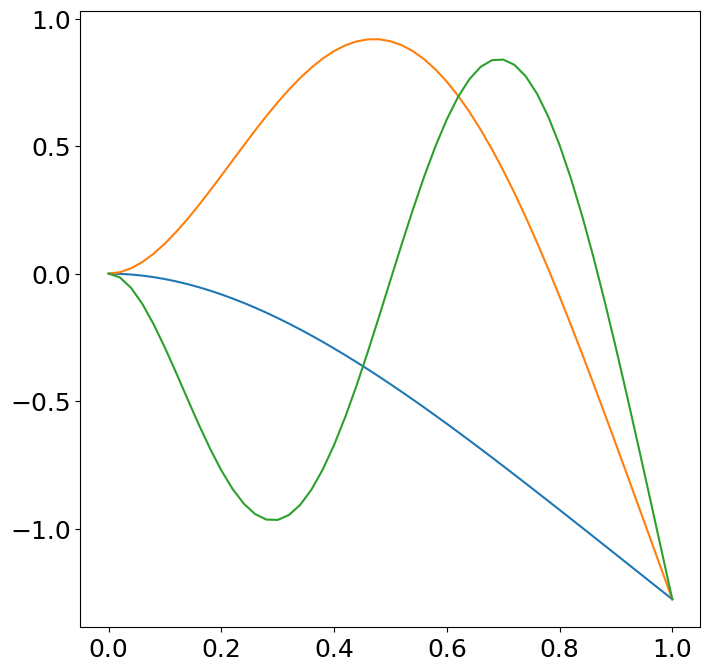

In [10]:
# ------------------ DISPLAY MODE SHAPES  ------------------ #
## ------ Modes to display ------ ##
mode_disp = np.array([
    0,1,2
])
## ------ Figure generation ------ ##
fig,ax = plt.subplots(1,1,figsize=(8,8))
for k in mode_disp:
    p = np.concatenate([np.zeros(2,),phi[:,k]])
    x = np.linspace(0,length_beam,number_nodes)
    y = p[0::2]
    ax.plot(x,y)

### 1.2.4. Creation of modal damping matrix

In the next block, a modal damping matrix is being created with a fixed value over all the modes.
In the modal space, the modal matrix is diagonal and given by : 
$$
\mathbb{C}_{mod} = \begin{bmatrix}
\ddots & 0 & 0 \\
 0 & 2\omega_{j}\xi & 0 \\
 0 & 0 & \ddots \\
\end{bmatrix}
$$

In the physical space, the transformation is given by : 
$$
\begin{aligned}
\mathbb{C}_{phys} & = (\phi)^{-1} \cdot \mathbb{C}_{mod} \cdot (\phi^{T})^{-1} \\ 
& = (\mathbb{M}\phi) \cdot \mathbb{C}_{mod} \cdot (\mathbb{M}\phi)^{T}, \\ 
\end{aligned}
$$
if the modes are normalized with respect to mass matrix $(\phi^{T}\mathbb{M}\phi)=1$.


It will be necessary to extend the damping matrix adding null vector lines and columns corresponding to the 2 dofs that are taken as clamped.

$$
\mathbb{C}_{phys}^{full} = 
\begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & \mathbb{C}_{phys} \\
\end{bmatrix}
$$

- Complete `generate_C_phys` function that returns the damping matrix in the physical space using a constant modal damping for all modes.

In [11]:
# ------------------ MODAL DAMPING PARAMETER  ------------------ #
xi = 1e-3
# ------------------ FUNCTION TO COMPLETE  ------------------ #
def generate_C_phys(om2:np.ndarray,phi:np.ndarray,xi:float,M:np.ndarray) -> np.ndarray:
    """
    Generates the modal equivalent damping matrix in the physical space
    
    Args: 
        om2 (np.ndarray): eigenvalues (square angular frequency)
        phi (np.ndarray): eigenvectors
        xi (float): modal damping value
        M (np.ndarray): mass matrix
        
    Returns:
        np.ndarray: modal damping matrix expressed in the physical space
    """
    C_mod = np.zeros(phi.shape) # build modal damping matrix
    C_phys =  np.zeros(phi.shape) # project in physical base using mass matrix C and phi or inverse of phi
    # Add the lines and column corresponding to clamped node
    # use np.block() function or np.concatenate
    C_phys = np.zeros((phi.shape[0]+2,phi.shape[1]+2))
    return C_phys
    
from Tuto_007_SuperElements_3D_Blade_correctionfunctions import generate_C_phys_corr
C_phys = generate_C_phys_corr(om2, phi, xi, Mcond)


### 1.2.5. Linear forced response

In the next block, a linear forced response is computed in order to analyse the response of the beam under a flexural forcing on the last node.

The damping matrix in the physical space is added in the substructure by modifying the matrix that are given. Then an `frf` analysis is built and added into the input dictionary and completed with the necessary connectors.

In [12]:
# ------------------ PARAMETERS   ------------------ #
K_STUCK = 1e3
# ------------------ DAMPING MATRIX INTO THE SUBSTRUCTURE  ------------------ #
beam_C_mat = copy.deepcopy(beam_null_mat)
beam_C_mat["C"] = C_phys

# ------------------ CONSTRUCTION OF THE INPUT DICT  ------------------ #
INP_lin = copy.deepcopy(INP)
INP_lin["substructures"]["beam"]["matrix"] = beam_C_mat

range_om = 20.
ds_max = 1e-1

## ------ Add connectors ------ ##
### --- Forcing --- ###
INP_lin["connectors"]["Forcing"] = {
    "type":"CosinusForcing",
    "connect":{"beam":[number_nodes-1]},
    "dirs":[0],
    "amp":1.
}
### --- Kinematic condition on the first node --- ###
INP_lin["kinematics"] = {
    "lock":{
        "type":"GOdisplacement",
        "connect":{"beam":[0]},
        "dirs":[0,1],
        "amp":0,
        "dto":0,
        "ho":1,
        
    }
}
## ------ Analysis construction ------ ##
INP_lin["analysis"] = {
    "FRF":{
        "study":"frf",
        "puls_inf":np.sqrt(om2)[0] - range_om,
        "puls_sup":np.sqrt(om2)[0] + range_om,
        "ds_min":ds_max/(2**10),
        "ds_max":ds_max,
        "reductors":[{"type":"AllgowerPreconditioner"}],
        "solver":"NewtonRaphson",
    }
}
# ------------------ COPY AND MAKE SECOND INPUT IN THE STUCK CONFIG  ------------------ #
INP_stuck = copy.deepcopy(INP_lin)
INP_stuck["connectors"]["FrictionLock"] = {
    "type":"LinearSpring",
    "connect":{"beam":[number_nodes-1]},
    "dirs":[0],
    "k":K_STUCK
}
# ------------------ CONSTRUCTION OF THE INPUT DICT  ------------------ #
L = pyHarm.Maestro(INP_lin)
L.operate("null")
Lstuck = pyHarm.Maestro(INP_stuck)
Lstuck.operate("null")

solution converged at om=25.60926894950908
solution converged at om=25.70926894338624
solution converged at om=25.80926893712604
solution converged at om=25.909268930724895
solution converged at om=26.009268924179118
solution converged at om=26.109268917484897
solution converged at om=26.209268910638308
solution converged at om=26.309268903635296
solution converged at om=26.409268896471687
solution converged at om=26.50926888914317
solution converged at om=26.609268881645292
solution converged at om=26.709268873022356
solution converged at om=26.809268865168185
solution converged at om=26.909268857130346
solution converged at om=27.00926884890378
solution converged at om=27.109268840483267
solution converged at om=27.209268831863415
solution converged at om=27.30926882303865
solution converged at om=27.409268814003216
solution converged at om=27.509268804751162
solution converged at om=27.60926879527634
solution converged at om=27.70926878443056
solution converged at om=27.809268774486

solution converged at om=44.60549549941822
solution converged at om=44.70413290243933
solution converged at om=44.80205123011885
solution converged at om=44.89874175402845
solution converged at om=44.99326267616619
solution converged at om=45.08389270575766
solution converged at om=45.167775280316484
solution converged at om=45.2412593823445


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.5083e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.52959e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.54843e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.60858e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.30171475867105
solution converged at om=45.349248812169364


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.79898e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.87964e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.9182e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.84375e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.386057237452796
solution converged at om=45.41475626475938


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.28379e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.30687e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.28925e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.28145e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.43751175575147
solution converged at om=45.45590663806816


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.63979e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.65412e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.66175e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.67082e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.471056232329026
solution converged at om=45.483745547786796


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.3457e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.30166e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.31586e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.31656e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.494534276234226
solution converged at om=45.50382860730405


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.21054e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.14118e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.15676e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.14083e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.51192890274132
solution converged at om=45.519061329007194


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.08958e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.09095e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10038e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.13885e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.525399085542254
solution converged at om=45.53107688008329


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.06933e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.08855e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10913e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.11307e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.53620097220723
solution converged at om=45.54085626387544


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.14131e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.13315e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.11109e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.11721e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.54511138951406
solution converged at om=45.549022427133096


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.08612e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.05236e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.02728e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.059e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLin

solution converged at om=45.5526356450721
solution converged at om=45.5559895613672


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.47184e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.77059e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.78174e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.57808e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.559116508566376
solution converged at om=45.56204383560904


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.74695e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.455e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.73781e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.7434e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLine

solution converged at om=45.56479484185136
solution converged at om=45.567389509490724


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.92498e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.66346e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.61116e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.60151e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.569845084100095
solution converged at om=45.57217653782117


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.04021e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.11349e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.20122e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.70336e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.57439694286103
solution converged at om=45.57651777455135


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.09119e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.41232e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.69497e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.27573e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.578549159007785
solution converged at om=45.580500076974644


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.6409e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.35792e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.81973e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.92535e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.58237853294911


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.80122e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.53465e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.25582e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.77534e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.58419169600534
solution converged at om=45.585946017788864


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.15465e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.10803e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.27893e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.24201e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.58764733255657


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.55612e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.48161e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.34784e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.5949e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.58930094162761


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.0615e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.27206e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.38768e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.95283e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.59091168572761


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.76984e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.6384e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.54886e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10283e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.59248400709213
solution converged at om=45.59402200310237


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.16291e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.12158e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.98301e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.06678e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.595529472815464


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.32876e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.33448e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.76799e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.24707e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.59700995810799


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.2477e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.09108e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.74072e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.25357e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.59846677919632


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.39081e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.04662e-20): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.82914e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.35254e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.59990306722574


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.95308e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.47584e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.11863e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.46756e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.6013217922974


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.02005e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.45371e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.53098e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.74448e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.60272578986226


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.89324e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.38462e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.63037e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.15082e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.17698e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.35841e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.37072e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.61665e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution not accepted at om=45.60411777094357


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.66174e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.05289e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.44843e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.88449e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.60342304239617


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.62445e-20): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.64598e-20): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.55267e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.66241e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution not accepted at om=45.59495913137226
solution converged at om=45.60377063813117


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.56548e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.19526e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.86182e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.67137e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.6041176081482


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.67131e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.86795e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.23954e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.92795e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.60446399315025


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.5509e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.57357e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.17201e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.13766e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.604809833481994


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.17273e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.78094e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.28817e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.55389e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.605155169315516


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.31137e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.73335e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.81584e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.16191e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.60584450639439


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.13718e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.09305e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.71078e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.0789e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.607219024643875


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.63174e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.91745e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.53768e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.44926e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.608589879137575


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.18477e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.46688e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.1111e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.12462e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.60995955011615


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.21628e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.30106e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.55808e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.67774e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.61133050910294


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.1444e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.67434e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.40372e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.54451e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.612705237124636


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.23049e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.16527e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.6389e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.93348e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.614086242371854


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.85327e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.09464e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.10519e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.24978e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.61547607901438


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.08658e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.92725e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.96623e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.28238e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.616877365620276


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.13571e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.70364e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.18048e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.57708e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.61829280636138


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.22828e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.08443e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.15076e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.17733e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.619725211463546


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.03906e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.54762e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.39425e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.83774e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.62117752119663


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.44508e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.21209e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.37923e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.579e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLin

solution converged at om=45.62265283086119


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.30748e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.76939e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.22007e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.66533e-19): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.624154419160014


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.31642e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.03647e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.47577e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.76631e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.62568577903629
solution converged at om=45.6272506530227


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.99335e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.37707e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.38059e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.76836e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.628853073044255
solution converged at om=45.63049740558902


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.84278e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.18695e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.69503e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.04316e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.63218840385247
solution converged at om=45.63393126818777


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.74834e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.54683e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.46156e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.5907e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.63573171560755
solution converged at om=45.637596062097636


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.88476e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.66291e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.19704e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.56605e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.63953131887742
solution converged at om=45.641545306283106


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.11789e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.27138e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.69491e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.05933e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.643646789769846
solution converged at om=45.64584564223023


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.606e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.4007e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.72633e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.48213e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLine

solution converged at om=45.64815304041449
solution converged at om=45.65058170232523


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.05409e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.2821e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.31077e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.30672e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.653146177870035
solution converged at om=45.65586320614095


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.01594e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.01089e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.8131e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.84579e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.65875215830466
solution converged at om=45.66183559093065


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.76244e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.49379e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.54933e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.55451e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.665139943632134
solution converged at om=45.6686964262683


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.03641e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.00729e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.00792e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.00689e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.672542158708964
solution converged at om=45.67672165089483


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.05252e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.13839e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10802e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.12211e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.68128874611013
solution converged at om=45.68630920578975


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.22788e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.24618e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.23304e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.23373e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.69186419178953
solution converged at om=45.69805502771493


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.24137e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.25121e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.22918e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.23816e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.70500980924636
solution converged at om=45.712892734829396


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.3259e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.41594e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.38574e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.40439e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.72191750436082
solution converged at om=45.73236689949288


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.53739e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.54205e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.50627e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.5271e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.74462187041142
solution converged at om=45.75920529820903


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.25247e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.2951e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.29507e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.32317e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.77684802907207
solution converged at om=45.79858641151093


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.44646e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.51388e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.5277e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.53128e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=45.82589444992995
solution converged at om=45.86081406456648


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.05222e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.28028e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.26323e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.26957e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=45.905906772185176
solution converged at om=45.96357852252246
solution converged at om=46.034498135802174
solution converged at om=46.11652584377927
solution converged at om=46.2060308855839
solution converged at om=46.299919683355014
solution converged at om=46.396257219747405
solution converged at om=46.49397307720585
solution converged at om=46.59248986734987
solution converged at om=46.69149048582031
solution converged at om=46.79079479832755
solution converged at om=46.89029657382509
solution converged at om=46.989930848789626
solution converged at om=47.08965654499882
solution converged at om=47.189446891654846
solution converged at om=47.28928396418854
solution converged at om=47.38915546756128
solution converged at om=47.489052783791784
solution converged at om=47.58896975380488
solution converged at om=47.688901898151116
solution converged at om=47.78884590699293
solution converged at om=47.88879929931919
solution converged at om=47.988760190884825
sol

solution converged at om=64.88847644602762
solution converged at om=64.98847643816357
solution converged at om=65.08847643046504
solution converged at om=65.18847642340498
solution converged at om=65.28847641602188
solution converged at om=65.38847640879189
solution converged at om=65.48847640171113
solution converged at om=65.5884763947758
solution converged at om=65.68847638798222
Wall clock time: 61.9294159412384
solution converged at om=25.60926894950908
solution converged at om=25.70926894923572
solution converged at om=25.809268948958348
solution converged at om=25.9092689486769
solution converged at om=26.009268948391313
solution converged at om=26.109268948101526
solution converged at om=26.209268947807473
solution converged at om=26.30926894750909
solution converged at om=26.409268947206307
solution converged at om=26.50926894689906
solution converged at om=26.609268946587274
solution converged at om=26.709268946270885
solution converged at om=26.809268945949817
solution conve

solution converged at om=43.609268633249634
solution converged at om=43.709268626594145
solution converged at om=43.80926861977513
solution converged at om=43.90926861278764
solution converged at om=44.00926860562656
solution converged at om=44.10926859756868
solution converged at om=44.20926859004065
solution converged at om=44.30926858232241
solution converged at om=44.40926857440803
solution converged at om=44.50926856629137
solution converged at om=44.60926855796604
solution converged at om=44.709268549425424
solution converged at om=44.80926853987973
solution converged at om=44.909268530883494
solution converged at om=45.00926852165045
solution converged at om=45.10926851217288
solution converged at om=45.2092685024428
solution converged at om=45.30926849245187
solution converged at om=45.40926848137414
solution converged at om=45.509268470830655
solution converged at om=45.60926845999921
solution converged at om=45.709268448870056
solution converged at om=45.80926843743306
soluti

/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.01132e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.0303e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.02736e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.03384e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.33191354742472
solution converged at om=60.38287738765477


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.95788e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.04957e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.04474e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.04692e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.42065204786516
solution converged at om=60.448851254100184


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.06437e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.11672e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.05914e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.07447e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.47041689436769
solution converged at om=60.487366080964705


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.61151e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.5913e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.28188e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.25251e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.50102975968506
solution converged at om=60.512292999769556


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.06025e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.0469e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.09865e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.06152e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.52175785216967
solution converged at om=60.52984467604406


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.82154e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.9372e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.88958e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.94694e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.53685453247378
solution converged at om=60.54300815703928


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.932e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.96209e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.85059e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.92384e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLin

solution converged at om=60.54847085429351
solution converged at om=60.55336879232944


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.81154e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.87096e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.84851e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.85308e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.55779992570696
solution converged at om=60.56184148436079


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.80849e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.74322e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.7432e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.74441e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.56555521548647
solution converged at om=60.568991123008026


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.38706e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.34762e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.34201e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.35042e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.572190182726345
solution converged at om=60.5751863450427


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.22676e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.17313e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.11621e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.06638e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.57800803446195
solution converged at om=60.58067928783382


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.32609e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.39264e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.46529e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.33034e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.58322062925787
solution converged at om=60.585649751312175


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.88128e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.97023e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.85527e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.33412e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.587982051242385
solution converged at om=60.59023105818981


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.47114e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.98741e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.65005e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.96883e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.59240877754643
solution converged at om=60.59452597173021


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.2942e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.79552e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.5171e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.9741e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLine

solution converged at om=60.59659239212217


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.08306e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.16514e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.49878e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.84278e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.598616973473746


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.83118e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.44069e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.33236e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.65868e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.600607998874764


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.34677e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.44196e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.38141e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.61317e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.60257324316598


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.17866e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.9199e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.51821e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.49947e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.604520098960656


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.0464e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.93644e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.28104e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.36869e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.606455690772215


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.91162e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.07639e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.97396e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.89759e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.60838698088072


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.17838e-20): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.94505e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.48451e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.61028e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.610320869831774


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.49232e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.78305e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.61463e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.47666e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.61226429547342


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.91053e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.03195e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.46406e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.38417e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.61422433274113
solution converged at om=60.61620829800142


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.88909e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.25631e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.86456e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.91119e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.61822386060323


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.23067e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.27652e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.63702e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.45961e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.620279165906446


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.6468e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.19748e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.48511e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.06141e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.62238297352048
solution converged at om=60.62454481690381


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.42289e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.71356e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.34705e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.2226e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.626775189212744
solution converged at om=60.62908576547805


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.47729e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.52024e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.40403e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.2048e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.63148967009161
solution converged at om=60.634001803676256


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.77463e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.72475e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.05903e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.88352e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.63663924792254
solution converged at om=60.63942177201421


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.31106e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.30564e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.27428e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.29841e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.642372474215364
solution converged at om=60.64551860329834


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.45024e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.46823e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.49398e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.59729e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.64889262425071
solution converged at om=60.65253361752976


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.78969e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.86414e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.85675e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.86885e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.65648914133805
solution converged at om=60.660817746996756


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.93774e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.8914e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.88913e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.89944e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.66559242927335
solution converged at om=60.67090544141304


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.0059e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.9944e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.97798e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.01068e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLin

solution converged at om=60.676875140821274
solution converged at om=60.68365592137502


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.0855e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.27051e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.23989e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.21536e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.69145294633899
solution converged at om=60.70054452248025


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.29106e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.34397e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.27574e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=2.29842e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.71131691866504
solution converged at om=60.72431982587516


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.05441e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.13061e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.10752e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.11918e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=60.740356229384325
solution converged at om=60.76062780553553


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.64489e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.77965e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.77902e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.8003e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=60.786956880337705
solution converged at om=60.822046656855676


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=8.90297e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.32054e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.31057e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=9.28449e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)


solution converged at om=60.8694365909106
solution converged at om=60.93211647651213
solution converged at om=61.0095697891231
solution converged at om=61.097412664929315
solution converged at om=61.19101276148502
solution converged at om=61.28751987822446
solution converged at om=61.38550448747851
solution converged at om=61.484275429138755
solution converged at om=61.58348827421603
solution converged at om=61.68296259806848
solution converged at om=61.78259886859252
solution converged at om=61.88233949041567
solution converged at om=61.982149689428745
solution converged at om=62.0820076730037
solution converged at om=62.18189933074621
solution converged at om=62.28181526071398
solution converged at om=62.381749037830986
solution converged at om=62.481696171763694
solution converged at om=62.58165346093806
solution converged at om=62.68161858136873
solution converged at om=62.78158981863724
solution converged at om=62.881565889382024
solution converged at om=62.98154582006433
solution

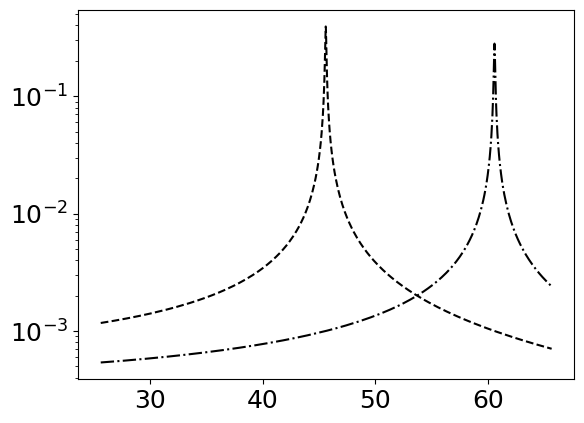

In [13]:
om,amp = get_frf(L,node=number_nodes-1)
om_stuck,amp_stuck = get_frf(Lstuck,node=number_nodes-1)

fig,ax = plt.subplots(1,1)
ax.plot(om,amp,"--k")
ax.plot(om_stuck,amp_stuck,"-.k")
ax.set_yscale("log")

### 1.2.6. Nonlinear analysis

We now add a friction connector at the end of the beam on the displacement component.

In [14]:
# ------------------ PARAMETERS   ------------------ #
MU = .3
N0 = 3e0
# ------------------ INPUT DICT CREATION   ------------------ #
INP_NL = copy.deepcopy(INP_lin)
INP_NL["connectors"]["Fric"] = {
    "type":"Jenkins",
    "connect":{"beam":[number_nodes-1]},
    "dirs":[0],
    "mu":MU,
    "N0":N0,
    "k":K_STUCK
}
NL = pyHarm.Maestro(INP_NL)
NL.operate("null")

solution converged at om=25.60926894950908
solution converged at om=25.70926894923572
solution converged at om=25.809268948958348
solution converged at om=25.9092689486769
solution converged at om=26.009268948391313
solution converged at om=26.109268948101526
solution converged at om=26.209268947807473
solution converged at om=26.30926894750909
solution converged at om=26.409268947206307
solution converged at om=26.50926894689906
solution converged at om=26.609268946587274
solution converged at om=26.709268946270885
solution converged at om=26.809268945949817
solution converged at om=26.909268945624
solution converged at om=27.009268945293357
solution converged at om=27.109268944957815
solution converged at om=27.209268944617296
solution converged at om=27.309268944271718
solution converged at om=27.409268943921006
solution converged at om=27.509268943565075
solution converged at om=27.609268943203844
solution converged at om=27.709268942837227
solution converged at om=27.8092689424651

solution converged at om=44.60926814658032
solution converged at om=44.70926804407557
solution converged at om=44.809267935249956
solution converged at om=44.90926779096371
solution converged at om=45.00926763308078
solution converged at om=45.10926743829922
solution converged at om=45.209267209011095
solution converged at om=45.30926692398434
solution converged at om=45.409266608540726
solution converged at om=45.50926615673745
solution converged at om=45.60926565498693
solution converged at om=45.709264932201705
solution converged at om=45.80926404878618
solution converged at om=45.909262793618744
solution converged at om=46.00926109357998
solution converged at om=46.10925856744228
solution converged at om=46.2092546656611
solution converged at om=46.30924729046186
solution converged at om=46.409232423803246


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.18353e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.00383e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=7.15942e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.9567e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLi

solution converged at om=46.50919089042131


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.84627e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.08469e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.01063e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=6.10876e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=46.60883404519918


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.22306e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=5.40755e-18): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.30099e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.15898e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonL

solution converged at om=46.70630686417956
solution converged at om=46.805973604990264


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=4.2097e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.3526e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.30877e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=3.36186e-17): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLin

solution converged at om=46.905874452744094
solution converged at om=47.00582745076832


/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10653e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10706e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)
/gpfs_new/data/users/qmercier/pyHarm/pyharm/Tutorials/../pyHarm/NonLinearSolver/NewtonRaphson.py:95: LinAlgWarning: Ill-conditioned matrix (rcond=1.10668e-16): result may not be accurate.
  return self.linearsolve(self.AXk,self.FXk)


solution converged at om=47.10580036391432
solution converged at om=47.20578209024211
solution converged at om=47.305768400563885
solution converged at om=47.40575589246879
solution converged at om=47.50574529307413
solution converged at om=47.60573587593202
solution converged at om=47.70572709674287
solution converged at om=47.80571937522468
solution converged at om=47.90571198198765
solution converged at om=48.00570520929627
solution converged at om=48.10569935168854
solution converged at om=48.205693388332136
solution converged at om=48.305688127126416
solution converged at om=48.40568344008107
solution converged at om=48.505678875033894
solution converged at om=48.605674724894314
solution converged at om=48.70567078318914
solution converged at om=48.80566736100181
solution converged at om=48.90566406826114
solution converged at om=49.00566079535583
solution converged at om=49.105657982628664
solution converged at om=49.20565530527832
solution converged at om=49.30565284972716
solut

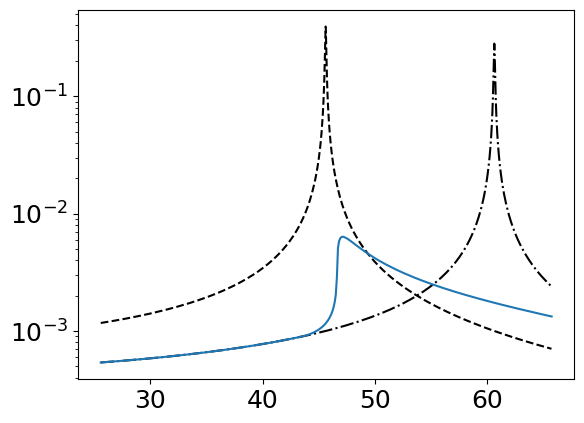

In [15]:
om_nl,amp_nl = get_frf(NL,node=number_nodes-1)

fig,ax = plt.subplots(1,1)
ax.plot(om,amp,"--k")
ax.plot(om_stuck,amp_stuck,"-.k")
ax.plot(om_nl,amp_nl)
ax.set_yscale("log")

### 1.2.7. Conclusion of the full model analysis

When the number of elements increases in the beam, the computation time grows really fast. When dealing with such system, it is possible to condense the dynamical behavior of the structure into a smaller model using component mode synthesis. In the next section, a reduced order model is being created. And the solving time will be compared.

## 1.3. Creation of a CRAIG BAMPTON super-element

In this section, a super-element is being created. The super-element allows for condensing the structure using linear modal behavior while keeping physical interfaces which can be interacted with. 

### 1.3.1. Partitioning of the matrices 

The first step in the creation of a super-element is the partitioning of the matrices in order to simplify the creation of the model. The usual partitioning of the dof vector consists in reordering the dof vector such that the dof that are used at interfaces are put at the top of the dof vector, while the dof that will be reduced into the modal space are put afterward. In the case of our beam, we want the dof vector :

$$
\begin{pmatrix}
\mathbf{u}_{b}\\
\mathbf{u}_{i}\\
\end{pmatrix} = 
\begin{pmatrix}
y_{0}\\
\theta_{0}\\
y_{end}\\
\theta_{end}\\
\mathbf{u}_{i}\\
\end{pmatrix},
$$
where $\mathbf{u}_{b}$ contains the boundary dofs and $\mathbf{u}_{i}$ the internal dofs

- Complete `rearange_matrices` function that rearranges the $\mathbb{M}$, $\mathbb{K}$, $\mathbb{C}_{phys}$ matrices according to the new partitioning

In [16]:
def rearange_matrices(M:np.ndarray,C:np.ndarray,K:np.ndarray) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    Arange_Mat = []
    for A in (M, C, K):
        A_part = None # using np.block, rearrange the matrix M, C, K
        Arange_Mat.append(A_part)
    return tuple(Arange_Mat)

from Tuto_007_SuperElements_3D_Blade_correctionfunctions import rearange_matrices_corr
Mp, Cp, Kp = rearange_matrices_corr(M, C_phys, K)
    
    

### 1.3.2 . Modal analysis with fixed interfaces 

The second step is to conduct a modal analysis considering the dofs that would remain in the physical domain clamped. 

- Extract the correct block of Mp and Kp matrices and make the modal analysis using the function provided in section *1.2.3.*
- Display the mode shape and the frequencies.

In [17]:
def get_phi_dyn(Mp,Kp):
    M_a, K_a = None, None # take the block of matrices that corresponds to the clamped-clamped beam
    om2_a, phi_a = make_modal_analysis(M_a, K_a)
    return om2_a, phi_a
    
    
from Tuto_007_SuperElements_3D_Blade_correctionfunctions import get_phi_dyn_corr
om2cb, phi_dyn = get_phi_dyn_corr(Mp, Kp)

pd.DataFrame({"Frequencies":(np.sqrt(om2cb)/(2*np.pi))})

Frequencies
0       46.190459
1      127.325824
2      249.609825
3      412.618878
4      616.384774
..            ...
93  249917.499493
94  253129.286561
95  255698.280945
96  257572.926512
97  258714.069184

[98 rows x 1 columns]

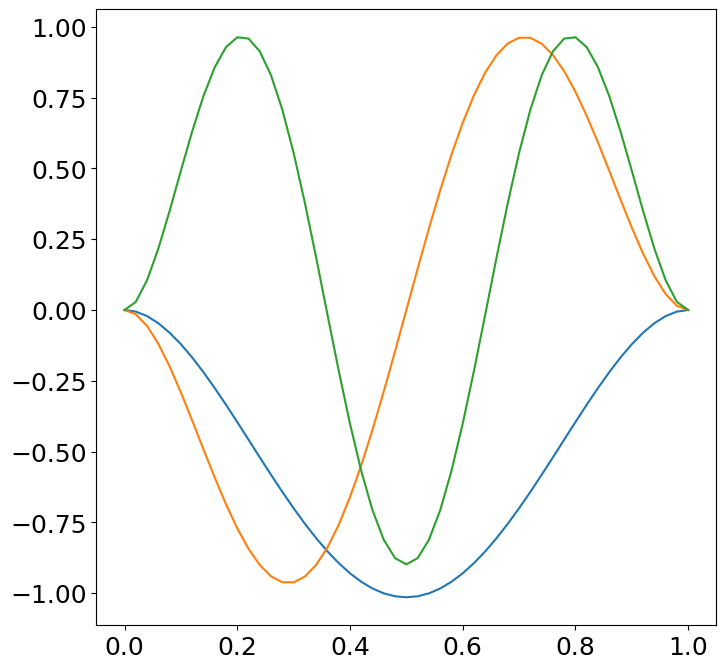

In [18]:
# ------------------ DISPLAY MODE SHAPES  ------------------ #
## ------ Modes to display ------ ##
mode_disp = np.array([
    0,1,2
])
## ------ Figure generation ------ ##
fig,ax = plt.subplots(1,1,figsize=(8,8))
for k in mode_disp:
    p = np.concatenate([np.zeros(2,),phi_dyn[:,k],np.zeros(2,)])
    x = np.linspace(0,length_beam,number_nodes)
    y = p[0::2]
    ax.plot(x,y)

### 1.3.3. Static modes 

The third step consists in completing the base obtained previously with static information only. 
A fast and easy way to obtain the static mode basis is to realise the following computation : 

$$
\phi^{stat} = -\mathbb{K}_{ii}^{-1}\mathbb{K}_{ib},
$$

where $\mathbb{K}$ is partitioned such that : 
$$
\mathbb{K}\cdot \mathbf{u} = 
\begin{bmatrix}
\mathbb{K}_{bb} & \mathbb{K}_{bi}\\
\mathbb{K}_{ib} & \mathbb{K}_{ii}\\
\end{bmatrix}
\cdot 
\begin{pmatrix}
\mathbf{u}_{b}\\
\mathbf{u}_{i}
\end{pmatrix}
$$

This is equivalent to load with a unitary force each dof that remains physical one by one and extract the displacement obtained for each linear system solved.


In [19]:
def get_phi_stat(Kp):
    K_ii, K_ib = None, None # take the right blocks of the rigidity matrix
    phi_stat = None # compute phi_stat
    return phi_stat

from Tuto_007_SuperElements_3D_Blade_correctionfunctions import get_phi_stat_corr
phi_stat = get_phi_stat_corr(Kp)

### 1.3.4. Assembly and mode truncature

The last step is to make the assembly of the different modes. The full transformation matrix is given by :
$$
\phi\cdot \mathbf{u} = 
\begin{bmatrix}
\begin{bmatrix} 1 & 0 & 0 \\ 0 & \ddots & 0 \\ 0 & 0 & 1  \end{bmatrix} & \begin{bmatrix} 0 & 0 & 0 \\ 0 & \ddots & 0 \\ 0 & 0 & 0  \end{bmatrix}\\
\phi^{stat} & \phi^{dyn}\\
\end{bmatrix}
\cdot 
\begin{pmatrix}
\mathbf{u}_{b}\\
\mathbf{u}_{i}
\end{pmatrix}
$$

Before building the full base, it is possible to truncate the $\phi^{dyn}$ in order to aim for interesting modes and reject modes that are not expected to play a role in the response.


In [20]:
# ------------------ PARAMETERS ------------------ #
## ------ selection of modes ------ ##
array_modes_kept = np.array([0]) # this can be modified in order to keep more mode shapes into the CB basis
phi_dyn_selec = phi_dyn[:,array_modes_kept]

## ------ Assembly ------ ##
def get_phi_cb(phy_dyn,phy_stat):
    phi = None # using np.block make the assembly of the basis
    return phi


from Tuto_007_SuperElements_3D_Blade_correctionfunctions import get_phi_cb_corr
phi_cb = get_phi_cb_corr(phi_dyn_selec, phi_stat)
    

### 1.3.5. Projection of the matrices in the new base

This is the last step of building our super-element. It only consists in projecting the matrices into the new reduced space for every matrices.

$$
\mathbb{A}^{gen} = (\phi^{CB})^{T}  \mathbb{A}  (\phi^{CB})
$$

In [21]:
def get_gen_matrices(Mp, Cp, Kp, phi_CB):
    list_A = []
    for A in (Mp, Cp, Kp) : 
        list_A.append(
        None # compute the matrix in generalised coordinates
        )
    return tuple(list_A)

from Tuto_007_SuperElements_3D_Blade_correctionfunctions import get_gen_matrices_corr
MCB, CCB, KCB = get_gen_matrices_corr(Mp, Cp, Kp, phi_cb)

### 1.3.6. Validation of the truncature

The truncature of the modal basis intoduces some approximation and information is lost. A good way of ensuring the modal truncature is sufficient is to check if the modal analysis of the Craig-Bampton reduced matrices returns the same frequencies.

By keeping the same boundary conditions as the full model, make the modal analysis of the Craig-Bampton reduced matrices and compare the obtained frequencies. If the error is too high, you can add more modes into the CB basis.

In [22]:
om2_red, phi_red = make_modal_analysis(MCB[2:,2:], KCB[2:,2:])
om2_red_ext = np.zeros(om2.shape)
om2_red_ext[np.arange(len(om2_red))] = om2_red
pd.DataFrame({"f_full":(np.sqrt(om2)/(2*np.pi)),
              "f_red":(np.sqrt(om2_red_ext)/(2*np.pi))})

f_full       f_red
0        7.258941    7.261460
1       45.491006   45.680922
2      127.376182  241.640841
3      249.606778    0.000000
4      412.619044    0.000000
..            ...         ...
95  252897.173611    0.000000
96  255559.946117    0.000000
97  257508.769639    0.000000
98  258697.605731    0.000000
99  309049.161569    0.000000

[100 rows x 2 columns]

## 1.4. Forced response on the reduced order model 

In this section, the reduced order model previously built is used into pyHarm and the same problem is solved. The reduced order model shall allow for a fast computation of the forced response curve compared to the full order model.

In [23]:
# ------------------ CREATION OF THE NEW SUBSTRUCTURE   ------------------ #
### --- New matrix with reduced model --- ###
beam_CB_mat = {
    "M":MCB,
    "C":CCB,
    "G":0*MCB,
    "K":KCB,
}
### --- Basic input --- ###
INP_CB = {
    "system":{
        "type":"Base",
        "nh":3,
        "nti":128
    },
    "substructures":{
        "beam":{
            "matrix":beam_CB_mat,
            "ndofs":2,
            "nmodes":len(array_modes_kept), # HERE THE NUMBER OF DYN MODES HAS TO BE GIVEN
        }
    },
    "connectors":{
    }
}

### --- Analysis --- ###
INP_CB["analysis"] = {
    "FRF":{
        "study":"frf",
        "puls_inf":np.sqrt(om2)[0] - range_om,
        "puls_sup":np.sqrt(om2)[0] + range_om,
        "ds_min":ds_max/(2**10),
        "ds_max":ds_max,
        "reductors":[{"type":"AllgowerPreconditioner"}],
        "solver":"NewtonRaphson",
    }
}
### --- Forcing --- ###
INP_CB["connectors"]["Forcing"] = {
    "type":"CosinusForcing",
    "connect":{"beam":[1]},
    "dirs":[0],
    "amp":1.
}
### --- Friction connector --- ###
INP_CB["connectors"]["Fric"] = {
    "type":"Jenkins",
    "connect":{"beam":[1]},
    "dirs":[0],
    "mu":MU,
    "N0":N0,
    "k":K_STUCK
}
### --- Kinematic condition on the first node --- ###
INP_CB["kinematics"] = {
    "lock":{
        "type":"GOdisplacement",
        "connect":{"beam":[0]},
        "dirs":[0,1],
        "amp":0,
        "dto":0,
        "ho":1,
        
    }
}

In [24]:
CB = pyHarm.Maestro(INP_CB)

In [25]:
CB.operate("null")

solution converged at om=25.60926894950908
solution converged at om=25.70926894949899
solution converged at om=25.809268949488757
solution converged at om=25.90926894947837
solution converged at om=26.00926894946783
solution converged at om=26.109268949456748
solution converged at om=26.209268949445896
solution converged at om=26.309268949434887
solution converged at om=26.409268949423716
solution converged at om=26.50926894941238
solution converged at om=26.60926894940046
solution converged at om=26.709268949388786
solution converged at om=26.80926894937694
solution converged at om=26.909268949364918
solution converged at om=27.00926894935272
solution converged at om=27.109268949339885
solution converged at om=27.20926894932732
solution converged at om=27.30926894931457
solution converged at om=27.409268949301634
solution converged at om=27.5092689492885
solution converged at om=27.609268949274686
solution converged at om=27.70926894926116
solution converged at om=27.809268949247432
s

solution converged at om=46.10926861591083
solution converged at om=46.20926849210244
solution converged at om=46.309268286236986
solution converged at om=46.40926790712363
solution converged at om=46.509266868875116
solution converged at om=46.609261916759415
solution converged at om=46.7091688678335
solution converged at om=46.80914485774357
solution converged at om=46.909139304726295
solution converged at om=47.00913710028632
solution converged at om=47.10913596937679
solution converged at om=47.20913526234783
solution converged at om=47.30913464421199
solution converged at om=47.40913416338457
solution converged at om=47.50913374699254
solution converged at om=47.60913337393343
solution converged at om=47.70913302462744
solution converged at om=47.80913272030363
solution converged at om=47.90913243702966
solution converged at om=48.00913217461724
solution converged at om=48.10913193293744
solution converged at om=48.209131718212284
solution converged at om=48.30913149970422
solutio

solution converged at om=65.70912809997893
Wall clock time: 4.166007995605469


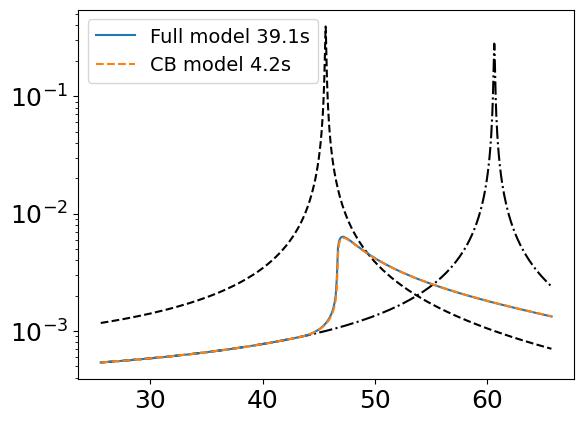

In [26]:
om_CBlin,amp_CBlin = get_frf(CB,node=1)

fig,ax = plt.subplots(1,1)
ax.plot(om,amp,"--k")
ax.plot(om_stuck,amp_stuck,"-.k")
ax.plot(om_nl,amp_nl,label=f"Full model {NL.timetosolve:0.1f}s")
ax.plot(om_CBlin,amp_CBlin,"--",label=f"CB model {CB.timetosolve:0.1f}s")
ax.set_yscale("log")
ax.legend(fontsize=14)

## 1.5. Conclusion 

Using super-elements, it is possible to greatly reduce the computation time of the forced response analysis. In the next section, the TurboTopo test case will be run using different reducers and number of harmonic configuration. 

# 2. TurboTopo test case 

In the following, the TurboTopo test case is run using different configurations of the analysis. TurboTopo is a test case consisting of two super-elements describing a bladed and a sector of disk in a forced response analysis. It is part of the non-regression test base. The super-elements are provided and the purpose of this section is to build the entire pyHarm model.

## 2.1. Read some input files and create the base input dictionary



In [14]:
# ------------------ SOME INPUTS FOR THE TEST CASE   ------------------ #
## ------ paths and file names ------ ##
path_inputs = "./DataTuto/" # path to Data folder
path_to_SE = "../tests/nonregression/NonRegressionData/turbotopo/" # path to SE folder for the test case
aube_SE_filename = "aube_ABQ.h5" # name of the h5 file for the blade SE 
disque_SE_filename = "disque_ABQ.h5" # name of the h5 file for the disk SE 

## ------ DataFrames for pairing nodes and local coordinates ------ ##
local_coordinates = pd.read_csv(path_inputs+"Tuto_007_CoordinateSystems.csv", index_col=[0]) 
pairing_nodes = pd.read_csv(path_inputs+"Tuto_007_pairing_nodes.csv", index_col=[0])


## ------ Preparation of the input dictionary ------ ##
INP = dict()
### --- Analysis setup --- ###
INP["analysis"] = dict()
INP["analysis"]["FRF"] = {
    "study":"frf",
    "puls_inf":5430.,
    "puls_sup":5465.,
    "ds_min":1e-08,
    "ds_max":1.0,
    "ds0":1.0,
    "verbose":True,
    "reductors":[{"type":"NLdofs"},{"type":"AllgowerPreconditioner"}]
}
### --- System setup --- ###
INP["system"] = {
    "type":"Base",
    "nh":1,
    "nti":64,
    "adim":{
        "status":False,
        "lc":1.6,
        "wc":5452.
    },
}
### --- Substructures setup --- ###
INP["substructures"] = dict()
INP["substructures"]["Aube"] = {
    "filename":path_to_SE+aube_SE_filename,
    "ndofs":3,
    'damping': {'Rayleigh': {'coef_M': 4.0, 'coef_K': 0.0}}
}
INP["substructures"]["Disque"] = {
    "filename":path_to_SE+disque_SE_filename,
    "ndofs":3,
    'damping': {'Rayleigh': {'coef_M': 4.0, 'coef_K': 0.0}}
}
### --- cooridnates init --- ###
INP["coordinates"] = dict()
### --- connectors init --- ###
INP["connectors"] = dict()

## 2.2. Add local coordinate system : 

The local coordinate system are defined in `INP["coordinates"]` dictionary.

```
INP["coordinates"][coordinate_system_name] = [
    list_defining_coordinates_of_first_direction,
    list_defining_coordinates_of_second_direction,
    list_defining_coordinates_of_third_direction,
]
```

- Complete `add_local_coordinate` that adds the local coordinate systems given in `local_coordinates` and returns the completed input dictionary

In [15]:
def add_local_coordinate(INP, local_coordinates):
    for l in local_coordinates : 
        series = local_coordinates[l]
        # insert the proper coordinate system in the coor 
        # use series.loc[name_of_direction] to get the list of coordinates returned as string
        # use eval() in order to convert it into a python list
        coor = [
            [0]*3,
            [0]*3,
            [0]*3
        ]
        INP["coordinates"][l] = coor # add the coordinate into the input dict
    return INP

from Tuto_007_SuperElements_3D_Blade_correctionfunctions import add_local_coordinate_corr
INP = add_local_coordinate_corr(INP, local_coordinates)

## 2.3. Build the forcing connector

Here the Forcing is added into the input dict. Bear in mind that the connectors are always built in the following way :

```
INP["connectors"][connector_name] = {
    "type":connector_type,
    "connect":{
        "name_slave_substructure":[node_slave_substructure],
        "name_master_substructure":[node_master_substructure],
        },
    "coordinatesystem":name_of_local_coordinate_system, # if necessary otherwise, uses the global
    "dirs":[list_of_directions],
    ... # other parameters of the connector
}
```

- Complete `add_forcing` that adds the forcing in the input dict (no local coordinate system is used for this connector)

In [16]:
def add_forcing(INP, forcing_name, forcing_sub, forcing_node, forcing_dir, forcing_amp=.1) : 
    # add the CosinusForcing connector into the input file
    return INP


from Tuto_007_SuperElements_3D_Blade_correctionfunctions import add_forcing_corr
INP = add_forcing_corr(INP, "Forcing", "Aube", 4, 1, .1)

## 2.4. Add the connectors between the blade and the disk

- Complete `add_friction_connectors_corr` that adds the friction and contact connectors between the blade and the disk with `DLFT3D` connetors. You shall use the information contained in `pairing_nodes` dataframe to know which nodes are connected to each other and using wich local coordinate system.

In [17]:
def add_friction_connectors(INP, pairing_nodes, **kwargs) : 
    type_con = kwargs["type_con"]
    mu_con = kwargs["mu"]
    N0_con = kwargs["N0"]
    g_con = kwargs["g"]
    jac_con = kwargs["jac"]
    eps_con = kwargs["eps"]
    dir_con = kwargs["dirs"]
    for i in pairing_nodes.index : 
        infos = pairing_nodes.loc[i]
        name_con = f"Con_Aube_{infos['Aube']:03d}_Disque_{infos['Disque']:03d}"
        INP["connectors"][name_con] = None
    return INP

from Tuto_007_SuperElements_3D_Blade_correctionfunctions import add_friction_connectors_corr
INP = add_friction_connectors_corr(INP, pairing_nodes,
                                  type_con = "DLFT3D",
                                  mu = .4,
                                  g = 0.,
                                  eps = 387828.,
                                  N0 = 70.,
                                  dirs = [0,1,2],
                                  jac = "jax")

## 2.5. Run the non-linear FRF analysis

- Build the Maestro instance corresponding to the input dictionary that has been built
- Run the Maestro using .operate() method

In [18]:
NL = pyHarm.Maestro(INP)
NL.operate()

solution converged at om=5430.0
solution converged at om=5430.999844955342
solution converged at om=5431.999659441232
solution converged at om=5432.999435488025
solution converged at om=5433.999162724643
solution converged at om=5434.998827171676
solution converged at om=5435.998409754733
solution converged at om=5436.997884028433
solution converged at om=5437.997215841391
solution converged at om=5438.99634342415
solution converged at om=5439.995193687189
solution converged at om=5440.99364490418
solution converged at om=5441.991509452071
solution converged at om=5442.988484721231
solution converged at om=5443.984090872161
solution converged at om=5444.977424329628
solution converged at om=5445.966907149086
solution converged at om=5446.949498105842
solution converged at om=5447.919124311295
solution converged at om=5448.863502821407
solution converged at om=5449.758249778834
solution converged at om=5450.523862983225
solution converged at om=5451.071695577968
solution converged at om

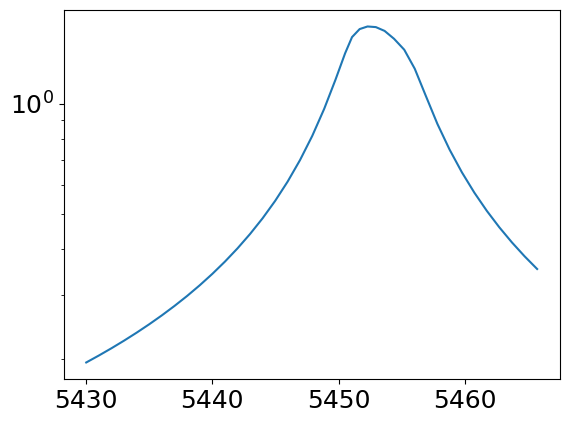

In [19]:
om, amp  = get_frf(NL, sub="Aube", node=4, direction=1, deriv=0)
fig,ax = plt.subplots(1,1,)
ax.plot(om, amp)
ax.set_yscale("log")

## 2.6. Conclusion

In this tutorial, you have first created elements/connectors that represent the elementary contribution of a Euler Bernoulli beam model, seeing that pyHarm allows for easy implementation of finite element residual contributions. The limitation of treating the full model in terms of computation time has been highlighted and the classical Craig Bampton super-element reduction process has been applied to the full model. This super-element has allowed a great speed-up when processing the analysis while keeping great precision. 

Then, you have built an entire model of a blade/disk interaction including friction contact.

This concludes the second block of tutorial for **pyHarm**